Retail Fashion Sales Analysis Return Prediction
Table of Contents:
1. Data Loading
2. Data Cleaning and Preprocessing
3. Exploratory Data Analysis
4. Correlation Analysis
5. Predictive Modeling
6. Summary and Next Steps

1. DATA LOADING

In [2]:
# Import necessary libraries and suppress warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')  # using Agg backend to save figures
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # switch backend if only plt is imported
%matplotlib inline

import seaborn as sns

# For predictive modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance

# Set aesthetic style for seaborn
sns.set(style="whitegrid")

In [5]:
# Load the dataset
# We choose to load from the CSV file. If needed, similar methods can be applied for xlsx or json files.
csv_path = r'C:\Users\LARISSA\Documents\TUTORIALPY/fashion_boutique_dataset.csv'
try:
    df = pd.read_csv(csv_path, encoding='ascii', delimiter=',')
    print('Data loaded successfully from CSV')
except Exception as e:
    print('Error loading CSV file:', e)

# Display the first few rows
df.head()

Data loaded successfully from CSV


,product_id,category,brand,season,size,color,original_price,markdown_percentage,current_price,purchase_date,stock_quantity,customer_rating,is_returned,return_reason
0,FB000001,Outerwear,Zara,Spring,XL,Red,196.01,0.0,196.01,2025-07-05,37,3.0,False,NaN
1,FB000002,Tops,Uniqlo,Winter,L,Pink,119.64,0.0,119.64,2025-08-06,2,2.5,False,NaN
2,FB000003,Accessories,Uniqlo,Winter,NaN,Black,33.80,0.0,33.80,2025-08-06,22,4.3,False,NaN
3,FB000004,Shoes,Uniqlo,Spring,XL,Black,75.36,0.0,75.36,2025-07-07,48,2.6,False,NaN
4,FB000005,Tops,Banana Republic,Winter,XL,Black,105.02,0.0,105.02,2025-08-06,10,NaN,False,NaN


2. Data Cleaning and Preprocessing

In [6]:
# Display basic info about the dataset
df.info()

# Convert the purchase_date column to datetime. Although the schema marks it as a string, we infer it is a date.
try:
    df['purchase_date'] = pd.to_datetime(df['purchase_date'])
    print('purchase_date column converted to datetime.')
except Exception as e:
    print('Error converting purchase_date:', e)

# Check for missing values
missing_vals = df.isnull().sum()
print('Missing values in each column:')
print(missing_vals)

# Optional: Fill or drop missing data as needed
# For demonstration, we will fill missing numeric customer_rating with the median and missing categorical with a placeholder
if 'customer_rating' in df.columns:
    df['customer_rating'] = df['customer_rating'].fillna(df['customer_rating'].median())

for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna('Unknown')

print('Missing values after imputation:')
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176 entries, 0 to 2175
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   product_id           2176 non-null   object 
 1   category             2176 non-null   object 
 2   brand                2176 non-null   object 
 3   season               2176 non-null   object 
 4   size                 1685 non-null   object 
 5   color                2176 non-null   object 
 6   original_price       2176 non-null   float64
 7   markdown_percentage  2176 non-null   float64
 8   current_price        2176 non-null   float64
 9   purchase_date        2176 non-null   object 
 10  stock_quantity       2176 non-null   int64  
 11  customer_rating      1814 non-null   float64
 12  is_returned          2176 non-null   bool   
 13  return_reason        320 non-null    object 
dtypes: bool(1), float64(4), int64(1), object(8)
memory usage: 223.3+ KB
purchase_date column

3. Exploratory Data Analysis

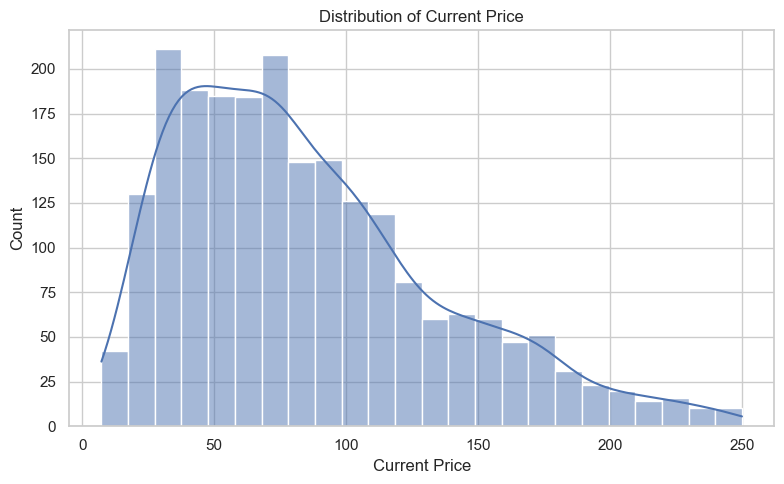

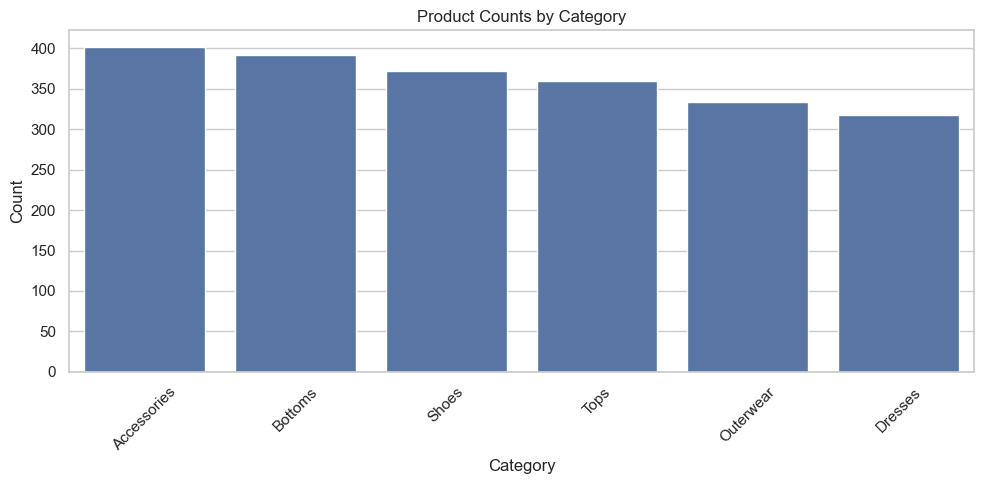

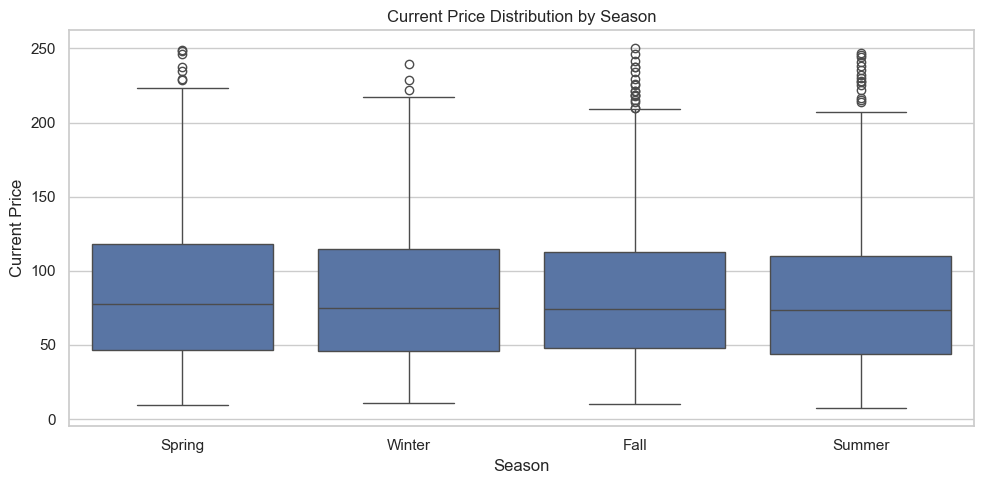

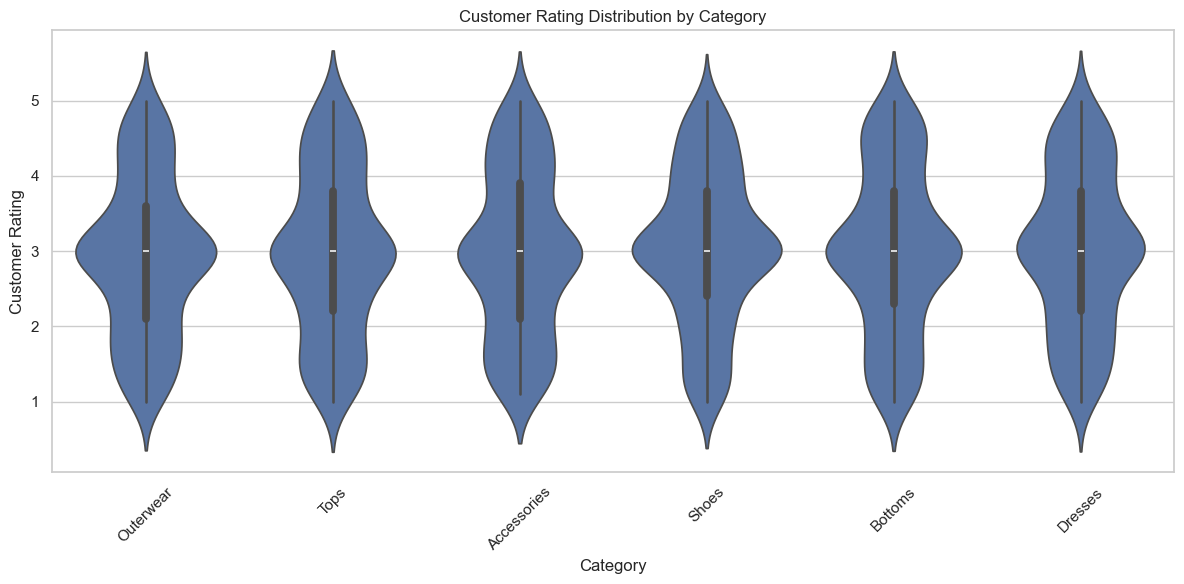

In [7]:
# Histogram of current_price
plt.figure(figsize=(8, 5))
sns.histplot(data=df, x='current_price', kde=True)
plt.title('Distribution of Current Price')
plt.xlabel('Current Price')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Bar plot for product categories
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='category', order=df['category'].value_counts().index)
plt.title('Product Counts by Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Box plot to show pricing by season
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='season', y='current_price')
plt.title('Current Price Distribution by Season')
plt.xlabel('Season')
plt.ylabel('Current Price')
plt.tight_layout()
plt.show()

# Violin plot for customer rating vs category
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x='category', y='customer_rating')
plt.title('Customer Rating Distribution by Category')
plt.xlabel('Category')
plt.ylabel('Customer Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

4. Correlation Analysis

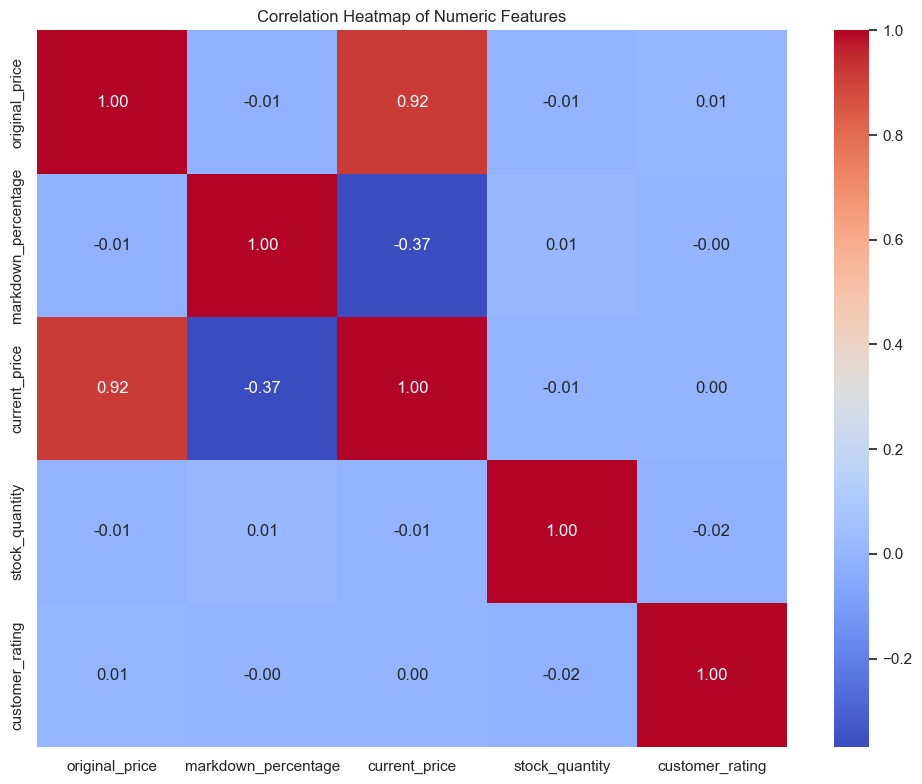

In [8]:
# Select only numeric columns from the dataframe
numeric_df = df.select_dtypes(include=[np.number])

if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(10, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.tight_layout()
    plt.show()
else:
    print('Not enough numeric columns for correlation heatmap analysis.')

5. Predictive Modeling

In [9]:
# Our goal: Predict whether a product is going to be returned (is_returned column)
# We will use a logistic regression model after encoding categorical features.

from sklearn.preprocessing import OneHotEncoder

# Select features for prediction. We include a mix of numeric and categorical features.
features = ['original_price', 'markdown_percentage', 'current_price', 'stock_quantity',
            'customer_rating', 'category', 'brand', 'season', 'size', 'color']

# Create a copy of the dataframe for modeling
model_df = df[features + ['is_returned']].copy()


In [10]:

# One-Hot Encode the categorical features
categorical_cols = ['category', 'brand', 'season', 'size', 'color']
model_df = pd.get_dummies(model_df, columns=categorical_cols, drop_first=True)

In [11]:
# Define X and y
X = model_df.drop('is_returned', axis=1)
y = model_df['is_returned']


Prediction Accuracy: 0.8744257274119449


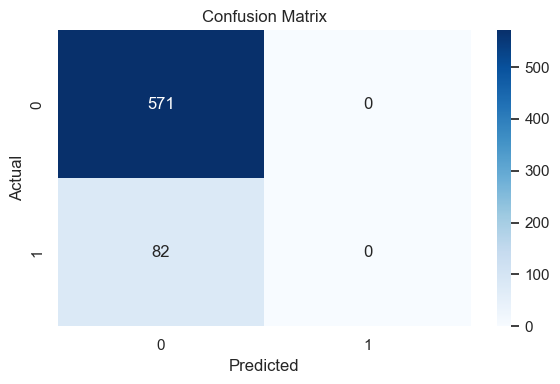

In [12]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Prediction Accuracy:', accuracy)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

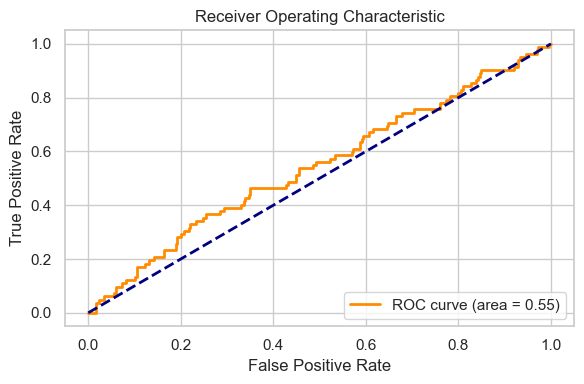

In [13]:
# ROC Curve
y_pred_proba = lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

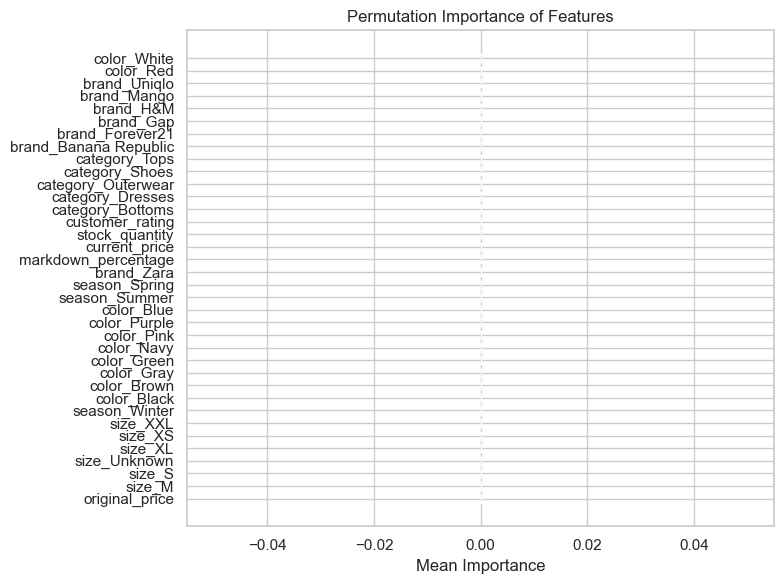

In [14]:
# Permutation Importance
result = permutation_importance(lr_model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(8, 6))
plt.barh(range(len(sorted_idx)), result.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), X_test.columns[sorted_idx])
plt.title('Permutation Importance of Features')
plt.xlabel('Mean Importance')
plt.tight_layout()
plt.show()

6. Summary and Next Steps


In this notebook, we loaded and preprocessed retail fashion boutique sales data to explore trends in pricing, customer ratings, and product returns. We produced various visualizations ranging from histograms and box plots to correlation heatmaps. Our predictive analysis used a logistic regression model to forecast product returns, complete with evaluation metrics such as accuracy, a confusion matrix, and an ROC curve.